# The Battle of Neighbourhoods: Health is Wealth!

_"Life is not to live, but to be well."_ - a quote by Martial

Introduction
============

Delhi - officially the National Capital Territory of Delhi (NCT) - is a city and union territory functioning as the capital of India. The NCT covers an area of 1484 square kilometres. According to the 2011 census, the NCT's population was about 16.8 million. Delhi is the second-wealthiest city in India after Mumbai and is home to 18 billionaires and 23000 millionaires. Delhi ranks fifth among the Indian states and union territories in human development index.

Hospitals complement and amplify the effectiveness of many other parts of the health system. Hospitals concentrate scarce resources within well-planned referral networks to respond efficiently to population health needs. They are an essential element of Universal Health Coverage and will be critical to meeting the Sustainable Development Goals. Medical institutions (also referred to as anchor institutions) play a major role in the social and economic vitality of cities. More than other industries, the hospital industry has the ability and incentive to leverage resources for community revitalization.

Statement of the Problem
========================

In a cosmopolis like Delhi - my home city - there exists high density of a burgeoning population, with ample demand for healthcare services, which are essential for a good quality of life, and increased longevity of the citizens. It would be mutually beneficial for citizens (whose health is at stake) and private investors (who would invest their wealth) and/or the government (that would look out for the welfare of its citizens) to know where to set up hospitals for addressing any shortage. This project aims to highlight the distribution of hospitals within Delhi's neighbourhoods and point out holes to be filled, so as to cater to the ever-growing demand. It's a "win-win situation" for all aforementioned stakeholders.

Data Collection
===============

The names of the neighbourhoods were scraped, using the pandas library, from [a Wikipedia page](https://en.wikipedia.org/wiki/List_of_constituencies_of_the_Delhi_Legislative_Assembly "Delhi's constituencies").

The coordinates of the 70 neighbourhoods were obtained via Geopy. If the latitude and longitude of a neighbourhood was not available through Geopy, Google was used as a last resort.

Foursquare location data (utilizing the "venues/explore" feature) will be processed to get the count of hospitals (category ID= '4bf58dd8d48988d196941735') within a radius of 2.5 kilometres ensconced within the neighbourhoods. The resulting json was flattened and converted to a pandas dataframe, whose shape[0] (number of rows) determined the hospital count for each neighbourhood.

The Folium library was the mapping tool selected to visualize the neighbourhoods clustered within the city of Delhi, using k-Means clustering.

Methodology
===========

Importing web-scraping libraries

In [1]:
import pandas as pd	# importing pandas

!conda install lxml --yes	# importing parser

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - lxml


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.9.11          |           py36_0         154 KB

The following packages will be UPDATED:

    certifi:         2019.9.11-py36_0     conda-forge --> 2019.9.11-py36_0 
    openssl:         1.1.1c-h516909a_0    conda-forge --> 1.1.1d-h7b6447c_2

The following packages will be DOWNGRADED:

    ca-certificates: 2019.9.11-hecc5488_0 conda-forge --> 2019.8.28-0      


certifi-2019.9.11    | 154 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Libraries imported.


Getting tables from the Wikipedia page

In [2]:
wp_pg_tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_constituencies_of_the_Delhi_Legislative_Assembly')
len(wp_pg_tables)

2

Having a look at the first table from the page

In [3]:
wp_pg_tables[0].head()

,Constituency No.,Name,Reserved for (SC/ST/None),District,Electors (2013),Lok Sabha constituency
0,1,Narela,None,North West Delhi,192649.0,North West Delhi
1,2,Burari,None,North West DelhiNorth Delhi,190130.0,North East Delhi
2,3,Timarpur,None,North West DelhiNorth Delhi,152679.0,North East Delhi
3,4,Adarsh Nagar,None,North West Delhi,137472.0,Chandni Chowk
4,5,Badli,None,North West Delhi,172342.0,North West Delhi


That's the table we want! Getting relevant table from the Wikipedia page and loading it into a dataframe

In [4]:
df = wp_pg_tables[0]

Dropping irrelevant columns from the dataframe

In [5]:
df1 = df.drop(['Constituency No.', 'Reserved for (SC/ST/None)', 'District', 'Electors (2013)', 'Lok Sabha constituency'], axis = 1)

Renaming column and having a look at the table

In [6]:
df1.rename(columns={'Name':'Neighbourhood'}, inplace=True)
df1.head()

,Neighbourhood
0,Narela
1,Burari
2,Timarpur
3,Adarsh Nagar
4,Badli


Tweaking the names of some neighbourhoods for processing via Geopy

In [7]:
df2 = df1.replace(regex={'Sultan Pur Majra': 'Sultanpur Majra', 'Nangloi Jat': 'Nangloi', 'Mangol Puri': 'Mangolpuri', 'Shakur Basti': 'Shakurbasti', 'Rajinder Nagar': 'Rajendra Nagar', 'Tughlkabad extension': 'Tughlakabad extension'})
df2.head(10)

,Neighbourhood
0,Narela
1,Burari
2,Timarpur
3,Adarsh Nagar
4,Badli
5,Rithala
6,Bawana
7,Mundka
8,Kirari
9,Sultanpur Majra


In [8]:
df2.shape[0]

70

There are 70 neighbourhoods in Delhi that we are interested in.

Importing various other libraries which will be required

In [12]:
import numpy as np # library to handle data in a vectorized manner

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from geopy.extra.rate_limiter import RateLimiter

import time

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


Function to get latitude and longitude of neighbourhoods

In [13]:
def getCoordinates(names):

    coords = []
    for name in names:
        print (name)
        
        address = name+', Delhi, India'

        geolocator = Nominatim(user_agent="delhi_explorer")
#        geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
        time.sleep(2)
        location = geolocator.geocode(address)
        if location != None:
            latitude = location.latitude
            longitude = location.longitude
        else:
            latitude = 0.0
            longitude = 0.0
        print('The geograpical coordinates are {}, {}.'.format(latitude, longitude))
        
        # return relevant information for each nearby venue
        coords.append([(
            name,
            latitude, 
            longitude)])
    
    coordinates = pd.DataFrame([item for coord_list in coords for item in coord_list])
    coordinates.columns = ['Neighbourhood', 
                  'Latitude', 
                  'Longitude']
    return (coordinates)

Utilizing above defined function to get neighbourhoods' coordinates

In [14]:
del_hoods = getCoordinates(names=df2['Neighbourhood'])

Narela
The geograpical coordinates are 28.8426096, 77.0918354.
Burari
The geograpical coordinates are 28.753882, 77.194833.
Timarpur
The geograpical coordinates are 28.70126285, 77.218679536312.
Adarsh Nagar
The geograpical coordinates are 28.6141925, 77.0715411848447.
Badli
The geograpical coordinates are 28.7337476, 77.1440045.
Rithala
The geograpical coordinates are 28.7208064, 77.1071813.
Bawana
The geograpical coordinates are 28.79966, 77.0328847.
Mundka
The geograpical coordinates are 28.6803941, 77.0304255.
Kirari
The geograpical coordinates are 28.6813917, 77.0535029.
Sultanpur Majra
The geograpical coordinates are 28.6893946, 77.0764331378285.
Nangloi
The geograpical coordinates are 28.6787059, 77.0671807.
Mangolpuri
The geograpical coordinates are 28.6873187, 77.0960253.
Rohini
The geograpical coordinates are 28.7162092, 77.1170743.
Shalimar Bagh
The geograpical coordinates are 28.71745265, 77.1508665461741.
Shakurbasti
The geograpical coordinates are 28.6814073, 77.1275679.


Geopy doesn't have coordinates of 2 neighbourhoods viz. Ghonda & Mustafabad. Used Google to get same and inserting manually in dataframe...

In [15]:
# manually entering Ghonda's coordinates
del_hoods.iloc[65, del_hoods.columns.get_loc('Latitude')] = 28.6903
del_hoods.iloc[65, del_hoods.columns.get_loc('Longitude')] = 77.2657

# manually entering Mustafabad's coordinates
del_hoods.iloc[68, del_hoods.columns.get_loc('Latitude')] = 28.7105
del_hoods.iloc[68, del_hoods.columns.get_loc('Longitude')] = 77.2699

Having a look at the modified dataframe

In [16]:
del_hoods.tail()

,Neighbourhood,Latitude,Longitude
65,Ghonda,28.690300,77.265700
66,Babarpur,28.687431,77.279755
67,Gokalpur,28.704990,77.292573
68,Mustafabad,28.710500,77.269900
69,Karawal Nagar,28.731141,77.274790


Getting coordinates of the city of Delhi

In [17]:
address = 'Delhi, India'

geolocator = Nominatim(user_agent="delhi_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Delhi are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Delhi are 28.6517178, 77.2219388.


Using Folium to display map of Delhi with neighbourhoods marked

In [18]:
# create map of Delhi using latitude and longitude values
map_delhi = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighbourhood in zip(del_hoods['Latitude'], del_hoods['Longitude'], del_hoods['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_delhi)  
    
map_delhi

The following cell contains the author's credentials

In [19]:
# The code was removed by Watson Studio for sharing.

Setting up variables for the Foursquare query

In [20]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

# Hospital category ID
ID = '4bf58dd8d48988d196941735'

Function to get count of hospitals in the neighbourhoods

In [21]:
def getNumHospitals(names, latitudes, longitudes, radius=2500):

    hosps = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print (name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            ID, 
            radius, 
            LIMIT)
        
        results = requests.get(url).json()
        
        venues = results['response']['groups'][0]['items']

        nearby_hosps = json_normalize(venues) # flatten JSON

        numHosps = nearby_hosps.shape[0]
        
        print(numHosps)
        
        # return count of each nearby hospital
        hosps.append([(
            name,
            latitude, 
            longitude,
            numHosps)])

    hood_hospitals = pd.DataFrame([item for hosp_list in hosps for item in hosp_list])
    hood_hospitals.columns = ['Neighbourhood', 
                              'Latitude', 
                              'Longitude',
                              'Count']
    
    return (hood_hospitals)

Using above defined function to get neighbourhoods' hospital counts

In [23]:
del_hosps = getNumHospitals(names = del_hoods['Neighbourhood'],
                            latitudes = del_hoods['Latitude'],
                            longitudes = del_hoods['Longitude']
			   )

Narela
1
Burari
1
Timarpur
2
Adarsh Nagar
6
Badli
7
Rithala
7
Bawana
1
Mundka
1
Kirari
1
Sultanpur Majra
2
Nangloi
2
Mangolpuri
5
Rohini
4
Shalimar Bagh
3
Shakurbasti
3
Tri Nagar
1
Wazirpur
1
Model Town
9
Sadar Bazar
11
Chandni Chowk
5
Matia Mahal
8
Ballimaran
4
Karol Bagh
3
Patel Nagar
2
Moti Nagar
10
Madipur
5
Rajouri Garden
3
Hari Nagar
5
Tilak Nagar
8
Janakpuri
8
Vikaspuri
4
Uttam Nagar
7
Dwarka
3
Matiala
12
Najafgarh
0
Bijwasan
0
Palam
4
Delhi Cantonment
1
Rajendra Nagar
4
New Delhi
3
Jangpura
4
Kasturba Nagar
4
Malviya Nagar
7
R K Puram
7
Mehrauli
5
Chhatarpur
5
Deoli
1
Ambedkar Nagar
3
Sangam Vihar
4
Greater Kailash
8
Kalkaji
1
Tughlakabad extension
4
Badarpur
1
Okhla
3
Trilokpuri
7
Kondli
2
Patparganj
6
Laxmi Nagar
10
Vishwas Nagar
16
Krishna Nagar
5
Gandhi Nagar
2
Shahdara
11
Seemapuri
10
Rohtas Nagar
10
Seelampur
3
Ghonda
4
Babarpur
6
Gokalpur
3
Mustafabad
3
Karawal Nagar
1


Having a look at the data types of the dataframe

In [24]:
del_hosps.dtypes

Neighbourhood     object
Latitude         float64
Longitude        float64
Count              int64
dtype: object

# k-Means Clustering

k-means clustering is a method of vector quantization, originally from signal processing, that is popular for cluster analysis in data mining. k-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells. In cluster analysis, the k-means algorithm can be used to partition the input data set into k partitions (clusters).

The term "k-means" was first used by James MacQueen in 1967, though the idea goes back to Hugo Steinhaus in 1956. The standard algorithm was first proposed by Stuart Lloyd of Bell Labs in 1957 as a technique for pulse-code modulation, though it wasn't published as a journal article until 1982. In 1965, Edward W. Forgy published essentially the same method, which is why it is sometimes referred to as Lloyd-Forgy.

Preparing dataframe and performing k-Means clustering by setting number of clusters to 3. k-Means is an unsupervised machine learning algorithm that suits our purpose as the data is such that it can be divided into 3 groups viz., good, middling, and deficient neighbourhoods.

In [25]:
del_cluster = del_hosps.iloc[:,3:] # Preparing dataframe for clustering

numClusters = 3 # Set number of clusters

del_kmeans = KMeans(n_clusters = numClusters, random_state = 0).fit(del_cluster) # Running k-Means Clustering

del_kmeans.labels_[0:10] # having a peek at the cluster labels

array([0, 0, 0, 2, 2, 2, 0, 0, 0, 0], dtype=int32)

Finalizing dataframe by adding cluster labels column

In [28]:
final_df = del_hoods # Preparing final dataframe
final_df['Hospital Count'] = del_hosps['Count']

final_df['Cluster Label'] = del_kmeans.labels_ # add clustering labels
final_df.head()

,Neighbourhood,Latitude,Longitude,Hospital Count,Cluster Label
0,Narela,28.842610,77.091835,1,0
1,Burari,28.753882,77.194833,1,0
2,Timarpur,28.701263,77.218680,2,0
3,Adarsh Nagar,28.614193,77.071541,6,2
4,Badli,28.733748,77.144004,7,2


Visualizing colour-coded clusters superimposed on the map of Delhi

In [29]:
# create map of Delhi using latitude and longitude values
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighbourhood, hcount, clust in zip(final_df['Latitude'], final_df['Longitude'], final_df['Neighbourhood'], final_df['Hospital Count'], final_df['Cluster Label']):
    label = '{}: {} hospitals'.format(neighbourhood, hcount)
    label = folium.Popup(label, parse_html=True)
    if clust == 1:
        ptColor="green" 
    elif clust == 0:
        ptColor = "red"
    else: 
        ptColor="yellow"
    folium.CircleMarker([lat, lng],
                        radius=5,
                        popup=label,
                        color=ptColor,
                        fill=True,
                        fill_color=ptColor,
                        fill_opacity=0.7,
                        parse_html=False).add_to(map_clusters)  
    
map_clusters

Elbow method for determining optimal number of clusters in k-Means clustering

In [30]:
elbow = []
for k in range(1, 11):
    km = KMeans(n_clusters = k, random_state = 0).fit(del_cluster)
    elbow.append(km.inertia_)

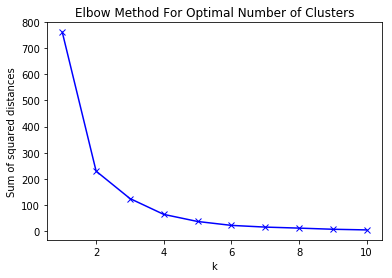

In [32]:
import matplotlib.pyplot as plt # importing graphing library
%matplotlib inline

K = range(1,11)

plt.plot(K, elbow,'bx-')
plt.xlabel('k')  
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

Results
=======

Bar graph showing saturation of hospitals in neighbourhoods

([<matplotlib.axis.XTick at 0x7f2cc10406d8>,
 <a list of 3 Text xticklabel objects>)

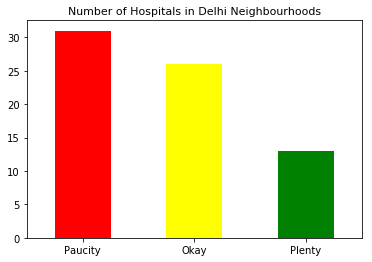

In [33]:
# Bar graph of data
final_df['Cluster Label'].value_counts().plot(kind = 'bar', color =['red', 'yellow', 'green'])
plt.title('Number of Hospitals in Delhi Neighbourhoods', fontsize = 11)
plt.xticks(np.arange(3), ('Paucity', 'Okay', 'Plenty'), rotation = 'horizontal')

In [34]:
Neighborhoods_Good = final_df[final_df['Cluster Label'] == 1]
Neighborhoods_Short = final_df[final_df['Cluster Label'] == 0]
Neighborhoods_Ok = final_df[final_df['Cluster Label'] == 2]
print('# of Neighborhoods with plenty of Hospitals: ' + str(len(Neighborhoods_Good)))
print('# of Neighborhoods with Hospital shortage: ' + str(len(Neighborhoods_Short)))
print('# of Neighborhoods with medium number of Hospitals: ' + str(len(Neighborhoods_Ok)))

# of Neighborhoods with plenty of Hospitals: 13
# of Neighborhoods with Hospital shortage: 31
# of Neighborhoods with medium number of Hospitals: 26


Sorting dataframe in descending order of hospital count

In [35]:
sorting_df = final_df.sort_values(by=['Hospital Count'], ascending=False)
sorted_df = sorting_df.reset_index(drop=True)

Top 10 neighbourhoods in terms of number of hospitals

In [36]:
sorted_df[['Neighbourhood', 'Hospital Count']].head(10) # Neighbourhoods with top 10 hospital count

,Neighbourhood,Hospital Count
0,Vishwas Nagar,16
1,Matiala,12
2,Shahdara,11
3,Sadar Bazar,11
4,Seemapuri,10
5,Rohtas Nagar,10
6,Laxmi Nagar,10
7,Moti Nagar,10
8,Model Town,9
9,Greater Kailash,8


Bottom 14 neighbourhoods with 0 or 1 hospital

In [37]:
sorted_df[['Neighbourhood', 'Hospital Count']].tail(14) # Neighbourhoods with 0 or 1 hospital count

,Neighbourhood,Hospital Count
56,Narela,1
57,Karawal Nagar,1
58,Badarpur,1
59,Kalkaji,1
60,Deoli,1
61,Delhi Cantonment,1
62,Burari,1
63,Wazirpur,1
64,Tri Nagar,1
65,Kirari,1


Discussion
==========

Analyzing the cluster map, it is manifest that there is more concentration of hospitals in central, and east Delhi. The density is sparse in north and west Delhi.

It is recommended that hospitals be set up in those neighbourhoods where their count is 0 or 1.

Also, capacity can be expanded in the isolated hospitals even as new hospitals come up in the vicinity.

For neighbourhoods where hospital count is in the green, existing hospitals should provide better healthcare to compete with other hospitals.

Conclusion
==========

The pervasive availability of healthcare is an index of the development of a nation, and a barometer of its citizens' happiness and longevity. Any issues in this field need to be addressed promptly.

It is evident that the city of Delhi needs more hospitals. We have found that there exists a glut of hospitals in some neighbourhoods while many others have paucity of the same.

The government should provide incentives to private investors so that they come forward to set up state-of-the-art medical centres in the requisite areas.

The government should also build hospitals to address the shortfall.

A good healthcare system is vital. It means the population has access to combat illness and therefore, there are no financial burdens, because of healthcare, on the country and the individual, due to a reliable workforce. This generates a thriving economy. "Health is Wealth!"